In [2]:
import torch
import torch.nn as nn

import pickle
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import sys
sys.path.append('/workspace/experiment')
from data.cifar10 import SplitCifar10, train_transform, val_transform
from data.capsule_split import get_splits

import os

import matplotlib.pyplot as plt
from glob import glob

In [3]:
# log_dir = "/workspace/experiment/log/NoiseGeneration/cifar10_s0/14"
log_dir = '/workspace/experiment/notebook/generate_feature'
glob(log_dir + "/*")

['/workspace/experiment/notebook/generate_feature/epoch=99-step=11799.ckpt']

In [4]:
checkpoint = torch.load(log_dir + "/epoch=99-step=11799.ckpt")

In [5]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.05)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)
        
class NoiseEncoder(nn.Module):
    def __init__(self, 
                 channel_in:  int,
                 channel_out: int,
                 kernel_size: int,
                 stride:      int,
                 padding:     int,
                 bias:        bool=False, 
                 num_classes: int=6,
                 alpha: float=1.0):
        
        super(self.__class__, self).__init__()
        self.conv = nn.Conv2d(channel_in, channel_out, kernel_size, stride, padding, bias=bias)
        self.bn = nn.BatchNorm2d(channel_out)
        self.bn_noise = nn.BatchNorm2d(channel_out)
        self.activation = nn.LeakyReLU(0.2)
        self.num_classes = num_classes
        self.register_buffer('buffer', None)
        self.alpha = alpha
        
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.activation(x)
        return x
    
    def forward_clean(self, x, class_mask):
        x = self.conv(x)
        self.cal_class_per_std(x, class_mask)
        x = self.bn(x)
        x = self.activation(x)
        return x
        
    def forward_noise(self, x, newY):
        x = self.conv(x)
        x = x + self.alpha * torch.normal(mean=0, std=self.buffer[newY]).type_as(x)
        x = self.bn_noise(x)
        x = self.activation(x)
        return x
    
    def cal_class_per_std(self, x, idxs):
        std = []
        for i in range(self.num_classes):
            x_ = x[idxs[i]].detach().clone()
            
            std.append(x_.std(0))
        self.buffer = torch.stack(std)

class classifier32(nn.Module):
    def __init__(self, num_classes=2, **kwargs):
        super(self.__class__, self).__init__()
        self.num_classes = num_classes
        self.num_classes = num_classes
        
        self.conv1 = NoiseEncoder(3,     64,    3, 1, 1, bias=False, num_classes=num_classes)
        self.conv2 = NoiseEncoder(64,    64,    3, 1, 1, bias=False, num_classes=num_classes)
        self.conv3 = NoiseEncoder(64,   128,    3, 2, 1, bias=False, num_classes=num_classes)
        
        self.conv4 = NoiseEncoder(128,  128,    3, 1, 1, bias=False, num_classes=num_classes)
        self.conv5 = NoiseEncoder(128,  128,    3, 1, 1, bias=False, num_classes=num_classes)
        self.conv6 = NoiseEncoder(128,  128,    3, 2, 1, bias=False, num_classes=num_classes)
        
        self.conv7 = NoiseEncoder(128,  128,    3, 1, 1, bias=False, num_classes=num_classes)
        self.conv8 = NoiseEncoder(128,  128,    3, 1, 1, bias=False, num_classes=num_classes)
        self.conv9 = NoiseEncoder(128,  128,    3, 2, 1, bias=False, num_classes=num_classes)
        
        self.fc = nn.Linear(128, num_classes * 2)
        self.dr1 = nn.Dropout2d(0.2)
        self.dr2 = nn.Dropout2d(0.2)
        self.dr3 = nn.Dropout2d(0.2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        self.apply(weights_init)
        
    def block0(self, x):
        x = self.dr1(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        return x
    
    def block1(self, x):
        x = self.dr2(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)

        return x
    
    def block2(self, x):
        x = self.dr3(x)
        x = self.conv7(x)
        x = self.conv8(x)
        x = self.conv9(x)
        
        x = self.avgpool(x)
        x = x.view(x.shape[0], -1)
        
        return x
        
    def forward(self, x):
        l1 = self.block0(x)
        l2 = self.block1(l1)
        l3 = self.block2(l2)
        
        y = self.fc(l3)
        
        return {
            'logit': y,
            'l3': l3,
            'l2': l2,
            'l1': l1,
        }
        
    def forward_l2(self, x):
        l3 = self.block2(x)
        
        logit = self.fc(l3)
        return {
            'logit': logit,
            'l3': l3
        }

In [6]:

model = classifier32(num_classes=6, alpha=0.1)
model_state_dict = model.state_dict()
for name, param in checkpoint['state_dict'].items():
    n = name.replace('model.', '')
    if n in model_state_dict.keys():
        model_state_dict[n].copy_(param)

In [7]:
split = get_splits('cifar10', 0)
known_data = SplitCifar10('/datasets', train=False, transform=val_transform, split=split['known_classes'])
open_data = SplitCifar10('/datasets', train=False, transform=val_transform, split=split['unknown_classes'])
known_loader = DataLoader(known_data, batch_size=32, shuffle=False, num_workers=4)
open_loader = DataLoader(open_data, batch_size=32, shuffle=False, num_workers=4)


In [8]:
test_input, test_target = next(iter(known_loader))
o_input, o_target = next(iter(open_loader))

In [9]:
model.eval()
model.to('cuda')
out = model(o_input.to('cuda'))
kOut = model(test_input.to('cuda'))

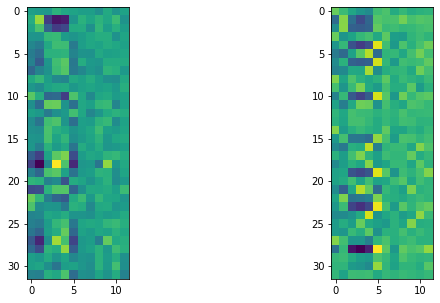

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(out['logit'].detach().cpu().numpy())
ax[1].imshow(kOut['logit'].detach().cpu().numpy())

In [11]:
kOut['logit'].max(-1)[1]

tensor([0, 1, 1, 0, 5, 4, 5, 4, 0, 3, 5, 3, 8, 3, 0, 5, 4, 3, 4, 5, 8, 3, 1, 5,
        4, 9, 4, 0, 5, 8, 5, 4], device='cuda:0')

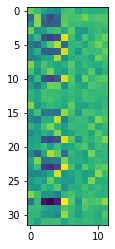

In [13]:
img = plt.imshow(kOut['logit'].detach().cpu().numpy())

In [122]:
model.to('cuda')
t_input = memory[2] * 0.5 + out['l2'][0]
# out2 = model.forward_l2(memory[0] + out['l2'][1])

<BarContainer object of 6 artists>

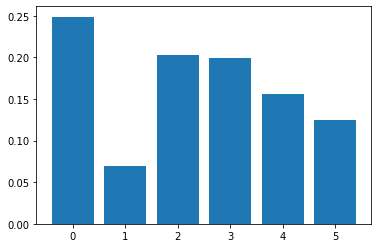

In [157]:
t_input = memory[4] * 0.5 + out['l2'][3] * 0.5
out2 = model.forward_l2(t_input.unsqueeze(0))
plt.bar(range(6), out2.softmax(-1).detach().cpu().numpy()[0])

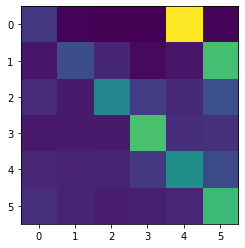

In [159]:
out3 = model.forward_l2(memory)
plt.imshow(out3.softmax(-1).detach().cpu().numpy())

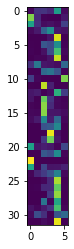

In [154]:
plt.imshow(t_out['logit'].softmax(-1).detach().cpu().numpy())

In [125]:
t_out = model(o_input.to('cuda'))

In [153]:
t_out['logit'].shape

torch.Size([32, 6])

In [160]:
split

{'known_classes': [0, 1, 2, 4, 5, 9], 'unknown_classes': [3, 6, 7, 8]}

In [1]:
import torch

In [2]:
import torch.nn as nn

In [3]:
sec = nn.Sequential(
    nn.Conv2d(3, 64, 3, 1, 1, bias=False),
    nn.Conv2d(64, 64, 3, 1, 1, bias=False),
)

In [4]:
sec.parameters()

<generator object Module.parameters at 0x7f1bcce58f20>